In [ ]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.0/309.0 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.4 MB/s eta 0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
from skimage.color import rgb2lab, lab2rgb
import os
import fiftyone
import fiftyone.zoo as foz
from PIL import Image
from skimage import color
import json
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as ski_psnr

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
JSON_PATH = "/content/drive/MyDrive/coco_train_image_paths.json"
COCO_DIR  = "/content/drive/MyDrive/COCO_2017"

os.makedirs(COCO_DIR, exist_ok=True)


def rebuild_and_save_coco_paths():
    print("Downloading COCO train split into Google Drive...")

    dataset = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    split="train",
    dataset_dir=COCO_DIR,
    overwrite=True)

    paths = dataset.values("filepath")

    print("Saving filepaths to Drive...")
    with open(JSON_PATH, "w") as f:
        json.dump(paths, f)

    print("Dataset rebuilt and saved.")
    return paths


def load_or_build_coco_paths():
    if os.path.exists(JSON_PATH):
        print("JSON found. Checking filepaths...")

        with open(JSON_PATH, "r") as f:
            paths = json.load(f)

        # Validate paths
        valid = [p for p in paths if os.path.exists(p)]
        print(f"Total in JSON: {len(paths)}, Valid: {len(valid)}")

        if len(valid) >= 0.95 * len(paths):
            print("Using cached dataset.")
            return valid

        print("Paths invalid: start rebuilding dataset")

    return rebuild_and_save_coco_paths()

image_paths = load_or_build_coco_paths()


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [16.5s elapsed, 0s remaining, 119.8Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [16.5s elapsed, 0s remaining, 119.8Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Downloading images to '/root/fiftyone/coco-2017/tmp-download/train2017.zip'


 100% |████|  144.1Gb/144.1Gb [18.8m elapsed, 0s remaining, 151.4Mb/s]      


INFO:eta.core.utils: 100% |████|  144.1Gb/144.1Gb [18.8m elapsed, 0s remaining, 151.4Mb/s]      


Extracting images to '/root/fiftyone/coco-2017/train/data'


INFO:fiftyone.utils.coco:Extracting images to '/root/fiftyone/coco-2017/train/data'


Writing annotations to '/root/fiftyone/coco-2017/train/labels.json'


INFO:fiftyone.utils.coco:Writing annotations to '/root/fiftyone/coco-2017/train/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'train'


TypeError: fiftyone.utils.data.importers.build_dataset_importer() got multiple values for keyword argument 'dataset_dir'

In [ ]:
# If COCO dataset already downloaded
import glob

COCO_IMAGE_DIR = "/root/fiftyone/coco-2017/train/data"
JSON_PATH = "/content/drive/MyDrive/coco_train_image_paths.json"

if os.path.exists(COCO_IMAGE_DIR):
    print(f"Using existing COCO images from {COCO_IMAGE_DIR}")
    image_paths = glob.glob(f"{COCO_IMAGE_DIR}/*.jpg")
    print(f"Found {len(image_paths)} images")

    # Sauvegarder dans Drive
    with open(JSON_PATH, "w") as f:
        json.dump(image_paths, f)
    print(f"Saved paths to Drive")
else:
    print("COCO images not found. Run download cell above.")
    image_paths = []

✓ Using existing COCO images from /root/fiftyone/coco-2017/train/data
✓ Found 118287 images
✓ Saved paths to Drive


In [ ]:
def compute_ab_weights_fast(image_paths, n_bins=20, epsilon=1e-6, save_file="ab_weights.json", sample_size=5000):
    """
    Computes AB rebalancing weights using a subset of images for speed.

    Args:
        image_paths (list): List of image file paths.
        n_bins (int): Number of bins per channel.
        epsilon (float): Small value to avoid division by zero.
        save_file (str): Path to save the weights JSON.
        sample_size (int): Number of images to sample for histogram.

    Returns:
        ab_weights (np.ndarray): Normalized AB rebalancing weights (n_bins x n_bins).
    """

    ab_hist = np.zeros((n_bins, n_bins), dtype=np.float32)

    # Randomly sample images
    if len(image_paths) > sample_size:
        sampled_paths = random.sample(image_paths, sample_size)
    else:
        sampled_paths = image_paths

    for idx, path in enumerate(sampled_paths):
        try:
            img = Image.open(path).convert("RGB")
            img = img.resize((128, 128))  # smaller size for faster processing
            img_np = np.array(img) / 255.0
            lab = color.rgb2lab(img_np)

            A = lab[:, :, 1]  # [-128, 127]
            B = lab[:, :, 2]

            # Convert to bins (discrete numbers)
            A_bin = ((A + 128) / 256 * n_bins).astype(int)
            B_bin = ((B + 128) / 256 * n_bins).astype(int)
            A_bin = np.clip(A_bin, 0, n_bins - 1)
            B_bin = np.clip(B_bin, 0, n_bins - 1)

            # histogram
            for a, b in zip(A_bin.flatten(), B_bin.flatten()):
                ab_hist[a, b] += 1

        except Exception as e:
            print(f"Error {path}: {e}")

        if idx % 500 == 0:
            print(f"Processed {idx}/{len(sampled_paths)} images")

    # Convert to probas
    ab_prob = ab_hist / ab_hist.sum()

    # Compute weights
    ab_weights = 1 / (ab_prob + epsilon)
    min_w, max_w = 0.5, 5.0 # we used to have 0-1 but it brought loss to 0
    ab_weights = ab_weights / ab_weights.max() * max_w
    ab_weights = torch.clamp(torch.tensor(ab_weights), min=min_w, max=max_w)

    # Save weights
    with open(save_file, "w") as f:
        json.dump(ab_weights.tolist(), f)

    print(f"Saved AB weights to {save_file}")
    return ab_weights

ab_weights = compute_ab_weights_fast(image_paths, sample_size=5000)


Processed 0/5000 images
Processed 500/5000 images
Processed 1000/5000 images
Processed 1500/5000 images
Processed 2000/5000 images
Processed 2500/5000 images
Processed 3000/5000 images
Processed 3500/5000 images
Processed 4000/5000 images
Processed 4500/5000 images
Saved AB weights to ab_weights.json


In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, image_paths, stats_file="/content/drive/MyDrive/ab_stats.json", weights_file="ab_weights.json", image_size=256):
        self.image_paths = image_paths
        self.image_size = image_size
        self.resize = transforms.Resize((image_size, image_size))

        # Load stats for normalizing data
        with open(stats_file, "r") as f:
            stats = json.load(f)
        self.ab_min = torch.tensor(stats["ab_min"]).float()
        self.ab_max = torch.tensor(stats["ab_max"]).float()

        # Load AB weights
        with open(weights_file, "r") as f:
            self.ab_weights = torch.tensor(json.load(f)).float()  # shape: (n_bins, n_bins)
        self.n_bins = self.ab_weights.shape[0]

    def normalize_ab(self, AB):
        AB_flat = AB.permute(1,2,0)
        AB_norm = (AB_flat - self.ab_min) / (self.ab_max - self.ab_min)
        AB_norm = AB_norm * 2 - 1
        return AB_norm.permute(2,0,1)

    def get_ab_weight_map(self, AB):
        A, B = AB[0], AB[1]  # shape (H,W)
        bin_idx_a = ((A + 128)/256 * self.n_bins).long().clamp(0, self.n_bins-1)
        bin_idx_b = ((B + 128)/256 * self.n_bins).long().clamp(0, self.n_bins-1)
        weight_map = self.ab_weights[bin_idx_a, bin_idx_b]
        return weight_map

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.resize(img)
        img = np.array(img)/255.0
        lab = color.rgb2lab(img)
        L = lab[:,:,0]
        A = lab[:,:,1]
        B = lab[:,:,2]

        L_norm = torch.tensor((L/50.0 -1.0)).float().unsqueeze(0)
        AB = torch.tensor(np.stack([A,B], axis=0)).float()
        AB_norm = self.normalize_ab(AB)

        weight_map = self.get_ab_weight_map(AB)

        return L_norm, AB_norm, weight_map

    def __len__(self):
        return len(self.image_paths)


In [ ]:
IMAGE_TRAIN_DIR = '/content/drive/MyDrive/Color/'

train_dataset = ColorizationDataset(image_paths)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ab_stats.json'

In [ ]:
stats = {
    "ab_min": train_dataset.ab_min.tolist(),
    "ab_max": train_dataset.ab_max.tolist()
}

with open("/content/drive/MyDrive/ab_stats.json", "w") as f:
    json.dump(stats, f)

print("Saved AB stats permanently to Drive!")


In [ ]:
train_dataset.ab_min, train_dataset.ab_max


In [ ]:
from sklearn.model_selection import train_test_split

train_paths, val_paths = train_test_split(image_paths, test_size=0.1, random_state=42)

# Créer ab_stats.json si nécessaire (première exécution)
STATS_FILE = "/content/drive/MyDrive/ab_stats.json"
if not os.path.exists(STATS_FILE):
    ab_min_list, ab_max_list = [], []
    sample_paths = random.sample(train_paths, min(1000, len(train_paths)))

    for i, path in enumerate(sample_paths):
        try:
            img = Image.open(path).convert("RGB").resize((128,128))
            lab = color.rgb2lab(np.array(img)/255.0)
            ab_min_list.append([lab[:,:,1].min(), lab[:,:,2].min()])
            ab_max_list.append([lab[:,:,1].max(), lab[:,:,2].max()])
        except:
            pass
        if i % 200 == 0:
            print(f"  Processed {i}/{len(sample_paths)}")

    ab_min = np.array(ab_min_list).min(axis=0).tolist()
    ab_max = np.array(ab_max_list).max(axis=0).tolist()

    with open(STATS_FILE, "w") as f:
        json.dump({"ab_min": ab_min, "ab_max": ab_max}, f)
    print(f"✓ Created {STATS_FILE}")
    print(f"  ab_min: {ab_min}")
    print(f"  ab_max: {ab_max}")
else:
    print(f"✓ Using existing {STATS_FILE}")

train_dataset = ColorizationDataset(train_paths)
val_dataset = ColorizationDataset(val_paths)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print(f"✓ Train: {len(train_dataset)} images | Val: {len(val_dataset)} images")

✓ Using existing /content/drive/MyDrive/ab_stats.json
✓ Train: 106458 images | Val: 11829 images


In [ ]:
class FCNConvBlock(nn.Module):
    # This block can perform a standard Conv (stride=1) or a Downsampling Conv (stride=2)
    def __init__(self, in_c, out_c, stride=1, norm=True):
        super().__init__()
        # 3x3 kernel with padding=1 to keep dimensions equal when stride=1
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(out_c) if norm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

class UpsampleBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # Nearest-neighbor unsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = FCNConvBlock(in_c, out_c, stride=1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        return x

In [ ]:
class DeepFCNColorizationAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 channel
        IN_C = 1

        #ENCODER (Contracting: 256 -> 16)

        # Level 1: 256x256 -> 128x128
        self.enc1 = FCNConvBlock(IN_C, 64, stride=1)
        self.down1 = FCNConvBlock(64, 128, stride=2)

        # Level 2: 128x128 -> 64x64
        self.enc2 = FCNConvBlock(128, 128, stride=1)
        self.down2 = FCNConvBlock(128, 256, stride=2)

        # Level 3: 64x64 -> 32x32
        self.enc3 = FCNConvBlock(256, 256, stride=1)
        self.down3 = FCNConvBlock(256, 512, stride=2)

        # Level 4: 32x32 -> 16x16
        self.enc4 = FCNConvBlock(512, 512, stride=1)

        # Bottleneck: 16x16x1024
        self.bottleneck = FCNConvBlock(512, 1024, stride=1)

        # DECODER (Expanding: 16 -> 256)

        # Level 4 Upsample: 16x16 -> 32x32. Skip connection from enc4 (512 channels)
        # Halve bottleneck channels: 1024 -> 512
        self.up4_prep = FCNConvBlock(1024, 512, stride=1)

        self.upsample4 = UpsampleBlock(512, 512)
        # Dec block input: 512 (up) + 512 (skip) = 1024
        self.dec4 = FCNConvBlock(512 + 512, 512)

        # Level 3 Upsample: 32x32 -> 64x64. Skip from enc3 (256 channels)
        self.upsample3 = UpsampleBlock(512, 256)
        # Dec block input: 256 (up) + 256 (skip) = 512
        self.dec3 = FCNConvBlock(256 + 256, 256)

        # Level 2 Upsample: 64x64 -> 128x128. Skip from enc2 (128 channels)
        self.upsample2 = UpsampleBlock(256, 128)
        # Dec block input: 128 (up) + 128 (skip) = 256
        self.dec2 = FCNConvBlock(128 + 128, 128)

        # Level 1 Upsample: 128x128 -> 256x256. Skip from enc1 (64 channels)
        self.upsample1 = UpsampleBlock(128, 64)
        # Dec block input: 64 (up) + 64 (skip) = 128
        self.dec1 = FCNConvBlock(64 + 64, 64)

        # Final Output Layer: 256x256x64 -> 256x256x2 (AB channels)
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # --- Encoder ---
        e1 = self.enc1(x)
        p1 = self.down1(e1)

        e2 = self.enc2(p1)
        p2 = self.down2(e2)

        e3 = self.enc3(p2)
        p3 = self.down3(e3)

        e4 = self.enc4(p3)

        b = self.bottleneck(e4)

        # --- Decoder ---

        # Level 4: 16 -> 32
        d4_prep = self.up4_prep(b)
        d4_up = self.upsample4(d4_prep)
        d4_up = F.interpolate(d4_up, size=e4.size()[2:], mode='nearest') # Ensure size match with e4
        d4 = torch.cat((d4_up, e4), dim=1)
        d4 = self.dec4(d4)

        # Level 3: 32 -> 64
        d3_up = self.upsample3(d4)
        d3_up = F.interpolate(d3_up, size=e3.size()[2:], mode='nearest') # Ensure size match with e3
        d3 = torch.cat((d3_up, e3), dim=1)
        d3 = self.dec3(d3)

        # Level 2: 64 -> 128
        d2_up = self.upsample2(d3)
        d2_up = F.interpolate(d2_up, size=e2.size()[2:], mode='nearest') # Ensure size match with e2
        d2 = torch.cat((d2_up, e2), dim=1)
        d2 = self.dec2(d2)

        # Level 1: 128 -> 256
        d1_up = self.upsample1(d2)
        d1_up = F.interpolate(d1_up, size=e1.size()[2:], mode='nearest') # Ensure size match with e1
        d1 = torch.cat((d1_up, e1), dim=1)
        d1 = self.dec1(d1)

        output = self.final_conv(d1)
        return self.tanh(output)

In [ ]:
def train_model(model, loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (L, AB_true, weight_map) in enumerate(loader):
            L, AB_true, weight_map = L.to(device), AB_true.to(device), weight_map.to(device)

            AB_pred = model(L)
            loss_map = criterion(AB_pred, AB_true) * weight_map.unsqueeze(1)
            loss = loss_map.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Log progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(loader)}], Loss: {loss.item():.4f}')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepFCNColorizationAutoencoder().to(device)

criterion = torch.nn.L1Loss(reduction="none")

optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, betas=(0.5, 0.999))


In [ ]:
#train_model(model,train_loader, criterion, optimizer)
#We tried pretraining the generator to make it stronger but it didn't add anything

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/generator_weights.pth")
print("Weights saved!")

Weights saved!


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # [H, W] -> [H/2, W/2]
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
#For CIFAR10 we had only 3 layers, we added new layers to capture increased complexity with COCO dataset
        self.layer4_new = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
#we tried with and without a 5th layer, but the 5th layer made it too strong
        #self.layer5_deep = nn.Sequential(
        #    nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=1),
        #    nn.BatchNorm2d(512),
        #    nn.LeakyReLU(0.2, inplace=True)
        #)
        self.final_conv = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, img_lab):

        x = self.layer1(img_lab) # Output: 128x128x64
        x = self.layer2(x)       # Output: 64x64x128
        x = self.layer3(x)       # Output: 32x32x256
        x = self.layer4_new(x)   # Output: 16x16x512
        #x = self.layer5_deep(x)
        output = self.final_conv(x) # Output: 16x16x1 (Probability Map)

        return output

In [ ]:
discriminator = Discriminator().to(device)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))

criterion_G_reconstruction = nn.L1Loss()

In [ ]:
def train_gan(generator, discriminator, loader, val_loader, criterion_recon, optim_G, optim_D, device, num_epochs=10):
    real_label, fake_label, criterion_adv, BEST_PSNR, lambda_recon = 0.8, 0.2, nn.BCEWithLogitsLoss(), -float("inf"), 70

    for epoch in range(num_epochs):
        epoch_loss_D, epoch_loss_G, epoch_loss_G_adv, epoch_loss_G_recon = 0, 0, 0, 0
        for i, (L, AB_true, weight_map) in enumerate(loader):
            L, AB_true, weight_map = L.to(device), AB_true.to(device), weight_map.to(device)

            # Discriminator
            optim_D.zero_grad()
            real_images = torch.cat((L, AB_true), dim=1)
            D_real = discriminator(real_images)
            with torch.no_grad(): AB_fake = generator(L)
            fake_images = torch.cat((L, AB_fake), dim=1)
            D_fake = discriminator(fake_images)
            loss_D = (criterion_adv(D_real, torch.full(D_real.shape, real_label, device=device)) +
                     criterion_adv(D_fake, torch.full(D_fake.shape, fake_label, device=device))) * 0.5
            loss_D.backward(); optim_D.step()

            # Generator
            optim_G.zero_grad()
            AB_fake = generator(L)
            fake_images_G = torch.cat((L, AB_fake), dim=1)
            D_G = discriminator(fake_images_G)
            loss_G_adv = criterion_adv(D_G, torch.full(D_G.shape, real_label, device=device))
            loss_G_recon = (criterion_recon(AB_fake, AB_true) * weight_map.unsqueeze(1)).mean()
            loss_G = loss_G_adv + lambda_recon * loss_G_recon
            loss_G.backward(); optim_G.step()

            epoch_loss_D += loss_D.item(); epoch_loss_G += loss_G.item()
            epoch_loss_G_adv += loss_G_adv.item(); epoch_loss_G_recon += loss_G_recon.item()

            if i % 500 == 0:
                print(f"[{epoch+1}/{num_epochs}][{i}/{len(loader)}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f} (Adv: {loss_G_adv.item():.4f}, Recon: {loss_G_recon.item():.4f})")

        # Validation & Metrics
        avg_psnr = evaluate_model(generator, val_loader, device)
        print(f"Epoch {epoch+1} | PSNR: {avg_psnr:.4f}")
        metrics['epoch'].append(epoch+1)
        metrics['loss_D'].append(epoch_loss_D/len(loader))
        metrics['loss_G'].append(epoch_loss_G/len(loader))
        metrics['loss_G_adv'].append(epoch_loss_G_adv/len(loader))
        metrics['loss_G_recon'].append(epoch_loss_G_recon/len(loader))
        metrics['psnr'].append(avg_psnr)

        if (epoch+1) % 5 == 0: save_metrics_plot(metrics)

        if avg_psnr > BEST_PSNR:
            BEST_PSNR = avg_psnr
            torch.save({'epoch': epoch, 'generator': generator.state_dict(), 'discriminator': discriminator.state_dict(),
                       'optim_G': optim_G.state_dict(), 'optim_D': optim_D.state_dict(), 'best_psnr': BEST_PSNR},
                      '/content/drive/MyDrive/best_checkpoint.pth')
            print(f"✓ Saved best model: PSNR={BEST_PSNR:.4f}")

In [ ]:
def calculate_psnr(L_input, AB_pred, AB_true):
    """
    Calculates the average PSNR for a batch of images.

    Args:
        L_input (torch.Tensor): The grayscale L channel (e.g., [B, 1, H, W]).
        AB_pred (torch.Tensor): The predicted A and B channels (e.g., [B, 2, H, W]).
        AB_true (torch.Tensor): The ground truth A and B channels (e.g., [B, 2, H, W]).

    Returns:
        float: The average PSNR across the batch.
    """
    import warnings
    warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

    L_np = L_input.detach().cpu().numpy()
    AB_pred_np = AB_pred.detach().cpu().numpy()
    AB_true_np = AB_true.detach().cpu().numpy()

    psnr_values = []

    # Iterate through each image in the batch
    for i in range(L_np.shape[0]):
        # Denormalize L channel from [-1, 1] back to [0, 100]
        L_denorm = (L_np[i, 0] + 1.0) * 50.0

        # Denormalize AB channels from [-1, 1] back to [-128, 127]
        AB_pred_denorm = np.transpose(AB_pred_np[i], (1, 2, 0)) * 128.0
        AB_true_denorm = np.transpose(AB_true_np[i], (1, 2, 0)) * 128.0

        # Combine L and AB to form the full LAB image (H, W, 3)
        LAB_pred = np.concatenate((L_denorm[:, :, np.newaxis], AB_pred_denorm), axis=2)
        LAB_true = np.concatenate((L_denorm[:, :, np.newaxis], AB_true_denorm), axis=2)

        # Convert to RGB for PSNR
        # lab2rgb assumes the L channel is [0, 100] (which it is)
        RGB_pred = lab2rgb(LAB_pred)
        RGB_true = lab2rgb(LAB_true)

        # Calculate PSNR
        psnr_val = ski_psnr(RGB_true, RGB_pred, data_range=1.0)
        psnr_values.append(psnr_val)

    return np.mean(psnr_values)

In [ ]:
def evaluate_model(generator, val_loader, device):
    generator.eval()
    total_psnr = 0.0
    num_batches = 0

    with torch.no_grad():
        for L, AB_true, weight_map in val_loader:
            L, AB_true = L.to(device), AB_true.to(device)
            AB_pred = generator(L)

            psnr_batch = calculate_psnr(L, AB_pred, AB_true)

            total_psnr += psnr_batch
            num_batches += 1

    generator.train()
    return total_psnr / num_batches

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/GANcheckpoint.pth", map_location=device)

model.load_state_dict(checkpoint["generator"])
discriminator.load_state_dict(checkpoint["discriminator"])

optimizer.load_state_dict(checkpoint["optim_G"])
optimizer_D.load_state_dict(checkpoint["optim_D"])

start_epoch = checkpoint["epoch"] + 1
BEST_PSNR = checkpoint["best_psnr"]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/GANcheckpoint.pth'

In [ ]:
train_gan(
    generator=model,
    discriminator=discriminator,
    loader=train_loader,
    val_loader=val_loader,
    criterion_recon=criterion_G_reconstruction,
    optim_G=optimizer,
    optim_D=optimizer_D,
    device=device,
    num_epochs=60
)


[1/60][0/1664] Loss_D: 0.7109 Loss_G: 10.8326 (Adv: 0.7427, Recon: 0.1441)
[1/60][500/1664] Loss_D: 0.5896 Loss_G: 5.5540 (Adv: 0.8919, Recon: 0.0666)
[1/60][1000/1664] Loss_D: 0.7476 Loss_G: 4.8887 (Adv: 0.6956, Recon: 0.0599)
[1/60][1500/1664] Loss_D: 0.6446 Loss_G: 5.0061 (Adv: 0.7174, Recon: 0.0613)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 31 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 611 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 15 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1306 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython

Epoch 1 | PSNR: 15.4721
✓ Saved best model: PSNR=15.4721
[2/60][0/1664] Loss_D: 0.7242 Loss_G: 5.2731 (Adv: 0.8464, Recon: 0.0632)
[2/60][500/1664] Loss_D: 0.6004 Loss_G: 5.0742 (Adv: 0.8355, Recon: 0.0606)
[2/60][1000/1664] Loss_D: 0.6691 Loss_G: 4.8506 (Adv: 0.7761, Recon: 0.0582)
[2/60][1500/1664] Loss_D: 0.6814 Loss_G: 5.0204 (Adv: 0.7784, Recon: 0.0606)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1088 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 480 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 431 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 544 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 585 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipyt

Epoch 2 | PSNR: 18.2542
✓ Saved best model: PSNR=18.2542
[3/60][0/1664] Loss_D: 0.7280 Loss_G: 4.5665 (Adv: 0.6827, Recon: 0.0555)
[3/60][500/1664] Loss_D: 0.6483 Loss_G: 5.1655 (Adv: 0.8156, Recon: 0.0621)
[3/60][1000/1664] Loss_D: 0.7279 Loss_G: 4.7649 (Adv: 0.6613, Recon: 0.0586)
[3/60][1500/1664] Loss_D: 0.5879 Loss_G: 5.1394 (Adv: 0.9143, Recon: 0.0604)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 708 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 838 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 359 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 254 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 440 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipyth

Epoch 3 | PSNR: 18.1418
[4/60][0/1664] Loss_D: 0.5815 Loss_G: 5.4777 (Adv: 1.0361, Recon: 0.0635)
[4/60][500/1664] Loss_D: 0.6524 Loss_G: 5.2157 (Adv: 0.8617, Recon: 0.0622)
[4/60][1000/1664] Loss_D: 0.6933 Loss_G: 4.9463 (Adv: 0.6953, Recon: 0.0607)
[4/60][1500/1664] Loss_D: 0.6562 Loss_G: 4.8933 (Adv: 0.7913, Recon: 0.0586)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 578 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 830 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 493 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3793 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1576 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipy

Epoch 4 | PSNR: 17.7922
[5/60][0/1664] Loss_D: 0.6008 Loss_G: 4.9790 (Adv: 0.8640, Recon: 0.0588)
[5/60][500/1664] Loss_D: 0.8040 Loss_G: 4.6929 (Adv: 0.7129, Recon: 0.0569)
[5/60][1000/1664] Loss_D: 0.6727 Loss_G: 4.7925 (Adv: 0.7823, Recon: 0.0573)
[5/60][1500/1664] Loss_D: 0.6428 Loss_G: 4.7936 (Adv: 0.8559, Recon: 0.0563)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 425 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1121 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 460 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 664 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 362 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipyt

Epoch 5 | PSNR: 16.7158
✓ Metrics saved: /content/drive/MyDrive/training_metrics.png (epoch 5)
[6/60][0/1664] Loss_D: 0.6219 Loss_G: 4.9943 (Adv: 0.8574, Recon: 0.0591)
[6/60][500/1664] Loss_D: 0.6826 Loss_G: 4.4528 (Adv: 0.7397, Recon: 0.0530)
[6/60][1000/1664] Loss_D: 0.6760 Loss_G: 4.8575 (Adv: 0.7125, Recon: 0.0592)
[6/60][1500/1664] Loss_D: 0.5521 Loss_G: 5.3029 (Adv: 1.0692, Recon: 0.0605)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 873 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 597 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)


Epoch 6 | PSNR: 18.4314
✓ Saved best model: PSNR=18.4314
[7/60][0/1664] Loss_D: 0.6587 Loss_G: 4.7390 (Adv: 0.7539, Recon: 0.0569)
[7/60][500/1664] Loss_D: 0.6244 Loss_G: 4.2820 (Adv: 0.7558, Recon: 0.0504)
[7/60][1000/1664] Loss_D: 0.6200 Loss_G: 4.8610 (Adv: 0.7929, Recon: 0.0581)
[7/60][1500/1664] Loss_D: 0.6341 Loss_G: 4.4456 (Adv: 0.7765, Recon: 0.0524)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 665 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1094 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1314 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1932 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 617 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ip

Epoch 7 | PSNR: 18.8416
✓ Saved best model: PSNR=18.8416
[8/60][0/1664] Loss_D: 0.6311 Loss_G: 4.8559 (Adv: 0.8021, Recon: 0.0579)
[8/60][500/1664] Loss_D: 0.6162 Loss_G: 4.2832 (Adv: 0.8035, Recon: 0.0497)
[8/60][1000/1664] Loss_D: 0.6962 Loss_G: 4.6404 (Adv: 0.7231, Recon: 0.0560)
[8/60][1500/1664] Loss_D: 0.5920 Loss_G: 4.7427 (Adv: 0.8981, Recon: 0.0549)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 577 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 779 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 917 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1441 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1450 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipy

Epoch 8 | PSNR: 18.1036
[9/60][0/1664] Loss_D: 0.7644 Loss_G: 4.5863 (Adv: 0.7963, Recon: 0.0541)
[9/60][500/1664] Loss_D: 0.5942 Loss_G: 4.4643 (Adv: 0.9342, Recon: 0.0504)
[9/60][1000/1664] Loss_D: 0.7398 Loss_G: 4.4151 (Adv: 0.6246, Recon: 0.0541)
[9/60][1500/1664] Loss_D: 0.6608 Loss_G: 4.5651 (Adv: 0.7433, Recon: 0.0546)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 669 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)


Epoch 9 | PSNR: 19.3548
✓ Saved best model: PSNR=19.3548
[10/60][0/1664] Loss_D: 0.5608 Loss_G: 4.8677 (Adv: 1.0361, Recon: 0.0547)
[10/60][500/1664] Loss_D: 0.5718 Loss_G: 4.7585 (Adv: 0.9438, Recon: 0.0545)
[10/60][1000/1664] Loss_D: 0.6725 Loss_G: 4.4413 (Adv: 0.7175, Recon: 0.0532)
[10/60][1500/1664] Loss_D: 0.6265 Loss_G: 4.8109 (Adv: 0.9071, Recon: 0.0558)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3369 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9200 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1452 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 18257 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 468 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/

Epoch 10 | PSNR: 18.6916
✓ Metrics saved: /content/drive/MyDrive/training_metrics.png (epoch 10)
[11/60][0/1664] Loss_D: 0.6094 Loss_G: 4.8781 (Adv: 0.8629, Recon: 0.0574)
[11/60][500/1664] Loss_D: 0.7383 Loss_G: 4.6948 (Adv: 0.8908, Recon: 0.0543)
[11/60][1000/1664] Loss_D: 0.5905 Loss_G: 4.6348 (Adv: 0.8861, Recon: 0.0536)
[11/60][1500/1664] Loss_D: 0.6770 Loss_G: 4.7052 (Adv: 0.8040, Recon: 0.0557)
Epoch 11 | PSNR: 18.6671
[12/60][0/1664] Loss_D: 0.5765 Loss_G: 4.4804 (Adv: 0.8874, Recon: 0.0513)
[12/60][500/1664] Loss_D: 0.7914 Loss_G: 4.2624 (Adv: 0.7845, Recon: 0.0497)
[12/60][1000/1664] Loss_D: 0.6605 Loss_G: 4.3473 (Adv: 0.7575, Recon: 0.0513)
[12/60][1500/1664] Loss_D: 0.5822 Loss_G: 4.7954 (Adv: 0.9317, Recon: 0.0552)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1579 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)


Epoch 12 | PSNR: 18.4787
[13/60][0/1664] Loss_D: 0.6262 Loss_G: 4.6490 (Adv: 0.8168, Recon: 0.0547)
[13/60][500/1664] Loss_D: 0.6431 Loss_G: 4.3436 (Adv: 0.7981, Recon: 0.0507)
[13/60][1000/1664] Loss_D: 0.6850 Loss_G: 4.5736 (Adv: 0.7201, Recon: 0.0551)
[13/60][1500/1664] Loss_D: 0.6702 Loss_G: 4.7323 (Adv: 0.7091, Recon: 0.0575)
Epoch 13 | PSNR: 18.7244
[14/60][0/1664] Loss_D: 0.7326 Loss_G: 4.2520 (Adv: 0.7457, Recon: 0.0501)
[14/60][500/1664] Loss_D: 0.6251 Loss_G: 4.4819 (Adv: 0.7768, Recon: 0.0529)
[14/60][1000/1664] Loss_D: 0.6907 Loss_G: 4.4373 (Adv: 0.7474, Recon: 0.0527)
[14/60][1500/1664] Loss_D: 0.6144 Loss_G: 4.6245 (Adv: 0.8082, Recon: 0.0545)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 454 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 846 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1688 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1267 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 927 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipy

Epoch 14 | PSNR: 19.4056
✓ Saved best model: PSNR=19.4056
[15/60][0/1664] Loss_D: 0.5608 Loss_G: 4.4658 (Adv: 0.9056, Recon: 0.0509)
[15/60][500/1664] Loss_D: 0.6213 Loss_G: 4.3881 (Adv: 0.7889, Recon: 0.0514)
[15/60][1000/1664] Loss_D: 0.6436 Loss_G: 4.6854 (Adv: 0.8893, Recon: 0.0542)
[15/60][1500/1664] Loss_D: 0.6342 Loss_G: 4.4093 (Adv: 0.7981, Recon: 0.0516)
Epoch 15 | PSNR: 19.4375
✓ Metrics saved: /content/drive/MyDrive/training_metrics.png (epoch 15)
✓ Saved best model: PSNR=19.4375
[16/60][0/1664] Loss_D: 0.7736 Loss_G: 4.1857 (Adv: 0.7224, Recon: 0.0495)
[16/60][500/1664] Loss_D: 0.6074 Loss_G: 4.6471 (Adv: 0.8709, Recon: 0.0539)
[16/60][1000/1664] Loss_D: 0.5836 Loss_G: 4.5357 (Adv: 0.9334, Recon: 0.0515)
[16/60][1500/1664] Loss_D: 0.7369 Loss_G: 4.4234 (Adv: 0.6367, Recon: 0.0541)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 608 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 721 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1195 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1758 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1557 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ip

Epoch 16 | PSNR: 19.2632
[17/60][0/1664] Loss_D: 0.6506 Loss_G: 4.2672 (Adv: 0.8752, Recon: 0.0485)
[17/60][500/1664] Loss_D: 0.6112 Loss_G: 4.2436 (Adv: 0.8860, Recon: 0.0480)
[17/60][1000/1664] Loss_D: 0.6194 Loss_G: 4.1691 (Adv: 0.8588, Recon: 0.0473)
[17/60][1500/1664] Loss_D: 0.6839 Loss_G: 4.2058 (Adv: 0.7133, Recon: 0.0499)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 869 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 937 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1438 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1813 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1539 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ip

Epoch 17 | PSNR: 17.9957
[18/60][0/1664] Loss_D: 0.6721 Loss_G: 4.8213 (Adv: 0.8812, Recon: 0.0563)
[18/60][500/1664] Loss_D: 0.6172 Loss_G: 4.4796 (Adv: 0.8385, Recon: 0.0520)
[18/60][1000/1664] Loss_D: 0.6820 Loss_G: 4.3723 (Adv: 0.7418, Recon: 0.0519)
[18/60][1500/1664] Loss_D: 0.5820 Loss_G: 4.5072 (Adv: 0.9577, Recon: 0.0507)
Epoch 18 | PSNR: 19.0238
[19/60][0/1664] Loss_D: 0.6726 Loss_G: 4.4887 (Adv: 0.9766, Recon: 0.0502)
[19/60][500/1664] Loss_D: 0.6317 Loss_G: 4.3944 (Adv: 0.7932, Recon: 0.0514)
[19/60][1000/1664] Loss_D: 0.6504 Loss_G: 4.4469 (Adv: 0.8211, Recon: 0.0518)
[19/60][1500/1664] Loss_D: 0.6429 Loss_G: 4.3513 (Adv: 0.8757, Recon: 0.0497)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 629 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 913 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1068 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 946 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 447 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipyt

Epoch 19 | PSNR: 19.2818
[20/60][0/1664] Loss_D: 0.6438 Loss_G: 4.0146 (Adv: 0.7659, Recon: 0.0464)
[20/60][500/1664] Loss_D: 0.6375 Loss_G: 3.9289 (Adv: 0.7573, Recon: 0.0453)
[20/60][1000/1664] Loss_D: 0.6813 Loss_G: 4.2366 (Adv: 0.7297, Recon: 0.0501)
[20/60][1500/1664] Loss_D: 0.6364 Loss_G: 4.2743 (Adv: 0.7775, Recon: 0.0500)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 466 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)


Epoch 20 | PSNR: 18.7507
✓ Metrics saved: /content/drive/MyDrive/training_metrics.png (epoch 20)
[21/60][0/1664] Loss_D: 0.6878 Loss_G: 4.6187 (Adv: 0.8366, Recon: 0.0540)
[21/60][500/1664] Loss_D: 0.6435 Loss_G: 4.1023 (Adv: 0.8223, Recon: 0.0469)
[21/60][1000/1664] Loss_D: 0.6846 Loss_G: 4.2016 (Adv: 0.8059, Recon: 0.0485)
[21/60][1500/1664] Loss_D: 0.6020 Loss_G: 4.0268 (Adv: 0.8746, Recon: 0.0450)
Epoch 21 | PSNR: 19.3280
[22/60][0/1664] Loss_D: 0.5665 Loss_G: 4.4994 (Adv: 0.9966, Recon: 0.0500)
[22/60][500/1664] Loss_D: 0.7112 Loss_G: 3.5276 (Adv: 0.7142, Recon: 0.0402)
[22/60][1000/1664] Loss_D: 0.6142 Loss_G: 4.4051 (Adv: 0.7989, Recon: 0.0515)
[22/60][1500/1664] Loss_D: 0.5879 Loss_G: 4.2063 (Adv: 0.9772, Recon: 0.0461)
Epoch 22 | PSNR: 18.8676
[23/60][0/1664] Loss_D: 0.5980 Loss_G: 4.5700 (Adv: 0.8473, Recon: 0.0532)
[23/60][500/1664] Loss_D: 0.6925 Loss_G: 4.3275 (Adv: 0.8040, Recon: 0.0503)
[23/60][1000/1664] Loss_D: 0.6956 Loss_G: 3.9813 (Adv: 0.7766, Recon: 0.0458)
[23/60]

/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 505 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 450 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)


Epoch 24 | PSNR: 18.2842
[25/60][0/1664] Loss_D: 0.7028 Loss_G: 4.3738 (Adv: 0.7562, Recon: 0.0517)
[25/60][500/1664] Loss_D: 0.5972 Loss_G: 4.1342 (Adv: 0.9376, Recon: 0.0457)
[25/60][1000/1664] Loss_D: 0.6411 Loss_G: 3.9281 (Adv: 0.8348, Recon: 0.0442)
[25/60][1500/1664] Loss_D: 0.6543 Loss_G: 4.5171 (Adv: 0.8421, Recon: 0.0525)
Epoch 25 | PSNR: 18.8398
✓ Metrics saved: /content/drive/MyDrive/training_metrics.png (epoch 25)
[26/60][0/1664] Loss_D: 0.6313 Loss_G: 4.2002 (Adv: 0.7632, Recon: 0.0491)
[26/60][500/1664] Loss_D: 0.6561 Loss_G: 4.0034 (Adv: 0.7518, Recon: 0.0465)
[26/60][1000/1664] Loss_D: 0.6607 Loss_G: 4.1173 (Adv: 0.8657, Recon: 0.0465)
[26/60][1500/1664] Loss_D: 0.5814 Loss_G: 4.5155 (Adv: 1.0655, Recon: 0.0493)


/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 855 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)
/tmp/ipython-input-562509518.py:34: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 590 negative Z values that have been clipped to zero
  RGB_pred = lab2rgb(LAB_pred)


Epoch 26 | PSNR: 19.6300
✓ Saved best model: PSNR=19.6300
[27/60][0/1664] Loss_D: 0.5721 Loss_G: 4.3101 (Adv: 0.9652, Recon: 0.0478)
[27/60][500/1664] Loss_D: 0.6172 Loss_G: 4.1063 (Adv: 0.8345, Recon: 0.0467)
[27/60][1000/1664] Loss_D: 0.6998 Loss_G: 3.9828 (Adv: 0.7352, Recon: 0.0464)
[27/60][1500/1664] Loss_D: 0.6656 Loss_G: 3.9067 (Adv: 0.8206, Recon: 0.0441)
Epoch 27 | PSNR: 19.5958
[28/60][0/1664] Loss_D: 0.6660 Loss_G: 4.1400 (Adv: 0.8593, Recon: 0.0469)
[28/60][500/1664] Loss_D: 0.6236 Loss_G: 4.0798 (Adv: 0.8082, Recon: 0.0467)
[28/60][1000/1664] Loss_D: 0.5891 Loss_G: 4.2578 (Adv: 0.9701, Recon: 0.0470)


KeyboardInterrupt: 

In [ ]:
# Since 60 epochs would take 20 hours of training with an A100, we stopped after 12 epochs and saved the model
#Results were already quite good. Next steps could be to train on several GPUs and reach the 60 epochs
'''torch.save({
    "epoch": 12,
    "generator": model.state_dict(),
    "discriminator": discriminator.state_dict(),
    "optim_G": optimizer.state_dict(),
    "optim_D": optimizer_D.state_dict(),
    "best_psnr": BEST_PSNR,
}, "/content/drive/MyDrive/GANcheckpoint.pth"
)

print("Checkpoint saved")'''


In [ ]:
def visualize_gan_output(generator, dataset, device, idx=0):
    """
    Visualizes:
      - Input grayscale L (model input)
      - Ground truth color
      - Generated GAN color
    """

    generator.eval()

    L, AB_true, _ = dataset[idx]
    L = L.unsqueeze(0).to(device)             # (1,1,H,W)
    AB_true = AB_true.unsqueeze(0).to(device) # (1,2,H,W)

    with torch.no_grad():
        AB_fake = generator(L)

    L_np = (L[0,0].cpu().numpy() * 100)   # L scaled to [0,100]
    AB_true_np = (AB_true[0].permute(1,2,0).cpu().numpy() * 128)
    AB_fake_np = (AB_fake[0].permute(1,2,0).cpu().numpy() * 128)

    lab_true = np.stack([L_np, AB_true_np[...,0], AB_true_np[...,1]], axis=-1)
    lab_fake = np.stack([L_np, AB_fake_np[...,0], AB_fake_np[...,1]], axis=-1)

    rgb_true = lab2rgb(lab_true)
    rgb_fake = lab2rgb(lab_fake)

    plt.figure(figsize=(14, 5))

    # Grayscale L
    plt.subplot(1, 3, 1)
    plt.title("Input L (Grayscale)")
    plt.imshow(L_np, cmap='gray')
    plt.axis("off")

    # Ground truth color
    plt.subplot(1, 3, 2)
    plt.title("Ground truth")
    plt.imshow(rgb_true)
    plt.axis("off")

    # GAN output
    plt.subplot(1, 3, 3)
    plt.title("GAN generated color")
    plt.imshow(rgb_fake)
    plt.axis("off")

    plt.show()


/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33575 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33779 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


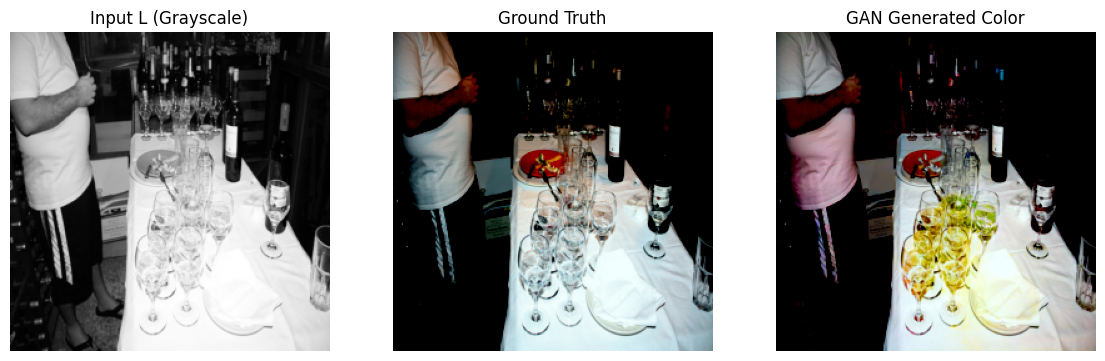

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 23063 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 21943 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


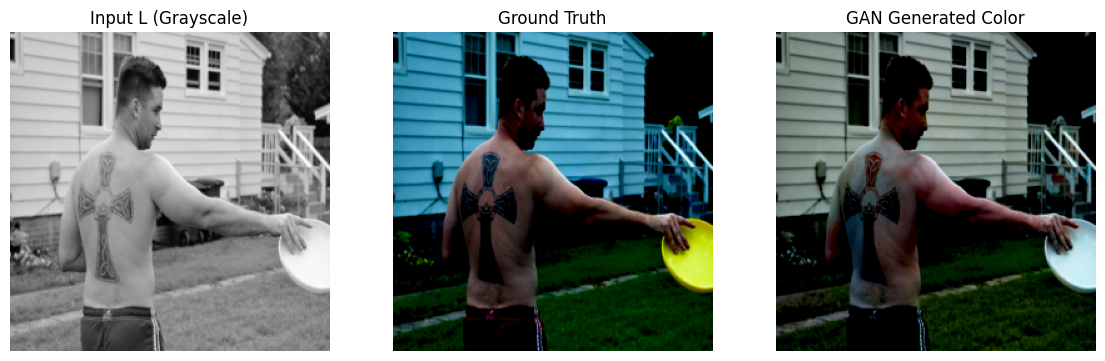

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9013 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8881 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


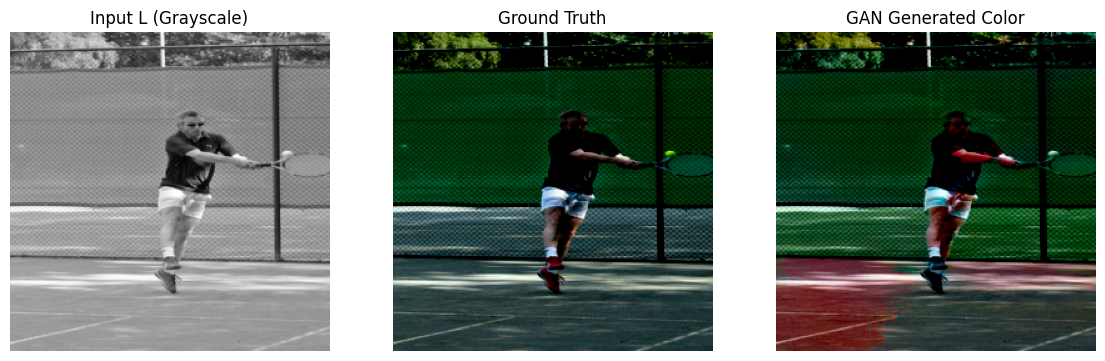

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 19697 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25184 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


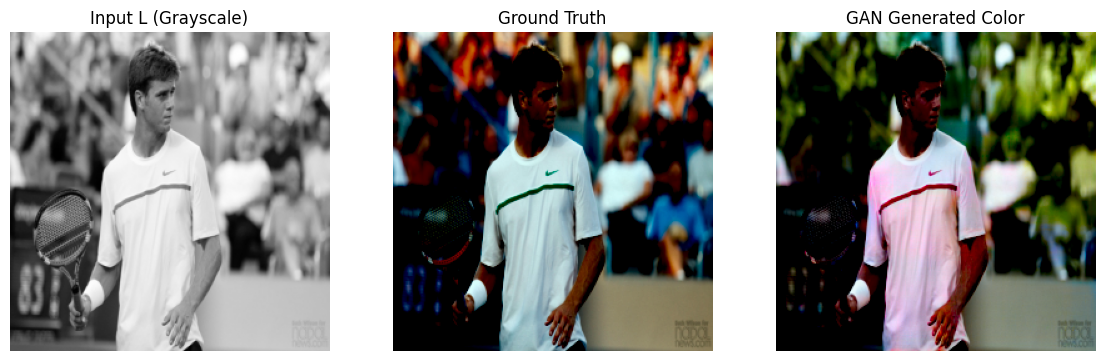

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40546 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 39496 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


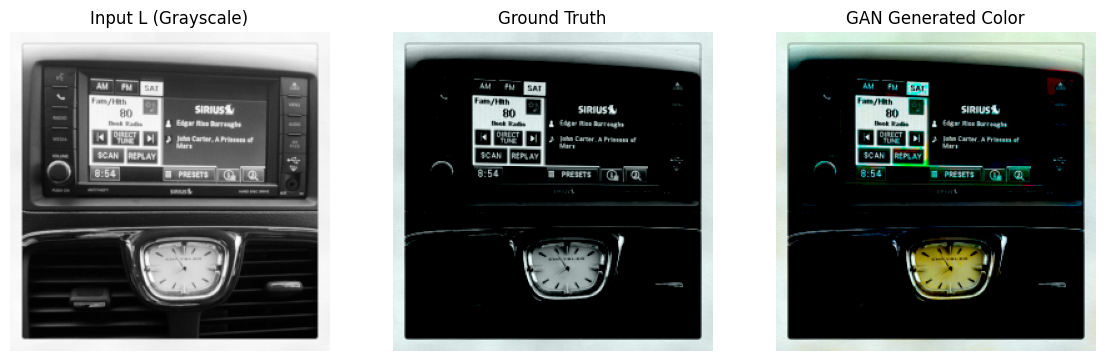

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 18335 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 20277 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


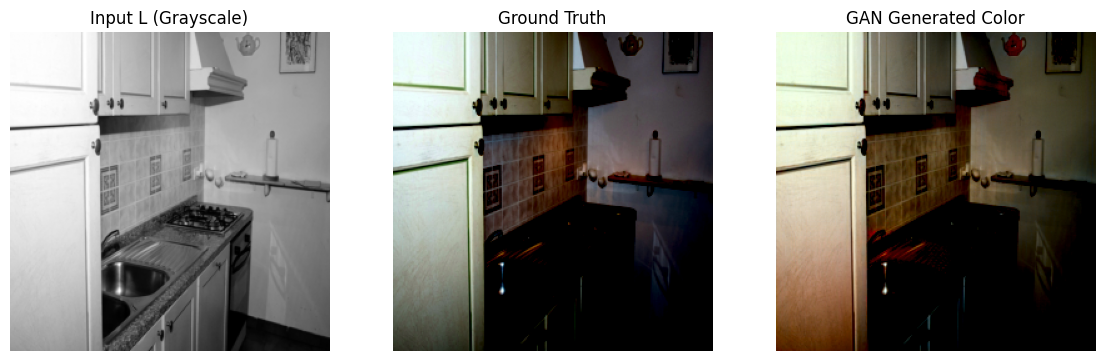

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33369 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 30978 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


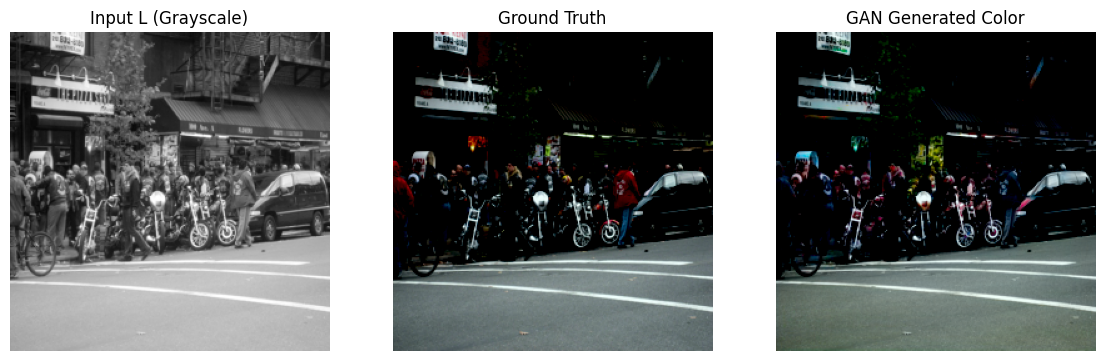

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 39036 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 41913 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


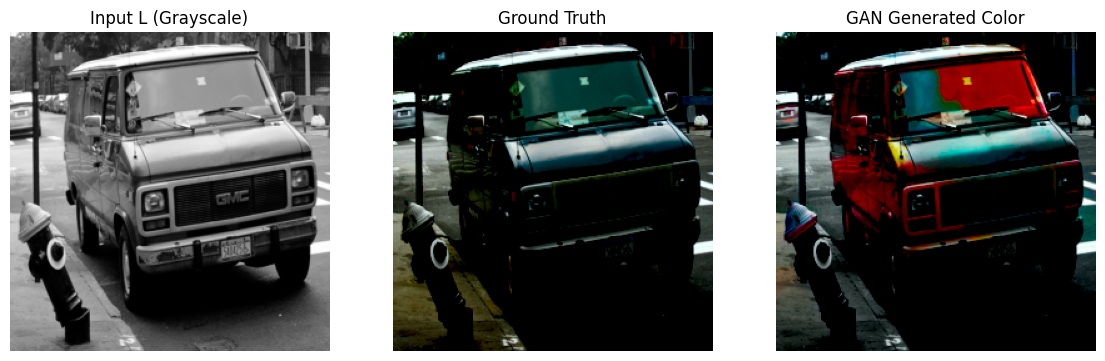

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 22571 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 22960 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


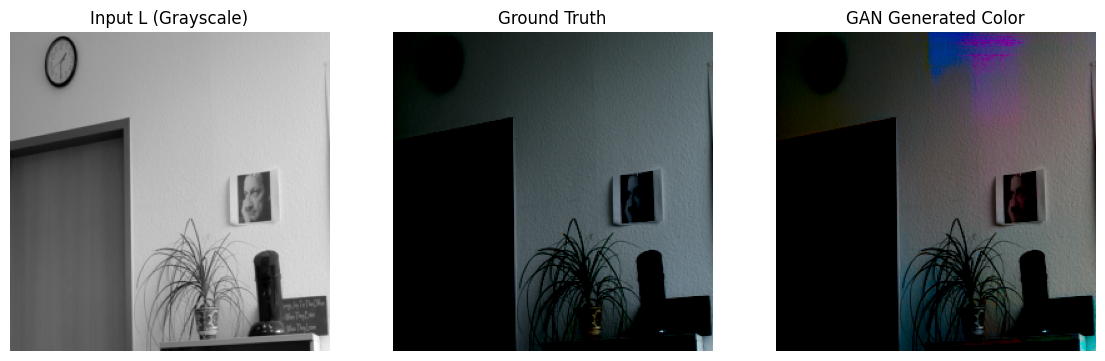

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 45214 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 37853 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


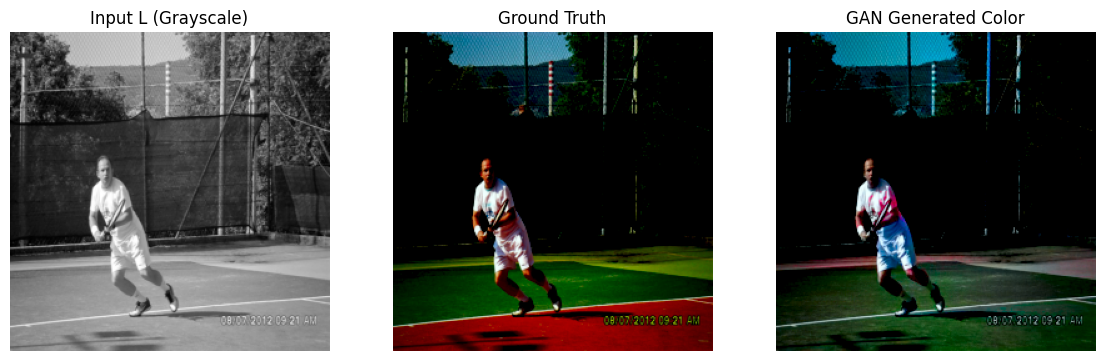

/tmp/ipython-input-3315568743.py:25: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10384 negative Z values that have been clipped to zero
  rgb_true = lab2rgb(lab_true)
/tmp/ipython-input-3315568743.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13973 negative Z values that have been clipped to zero
  rgb_fake = lab2rgb(lab_fake)


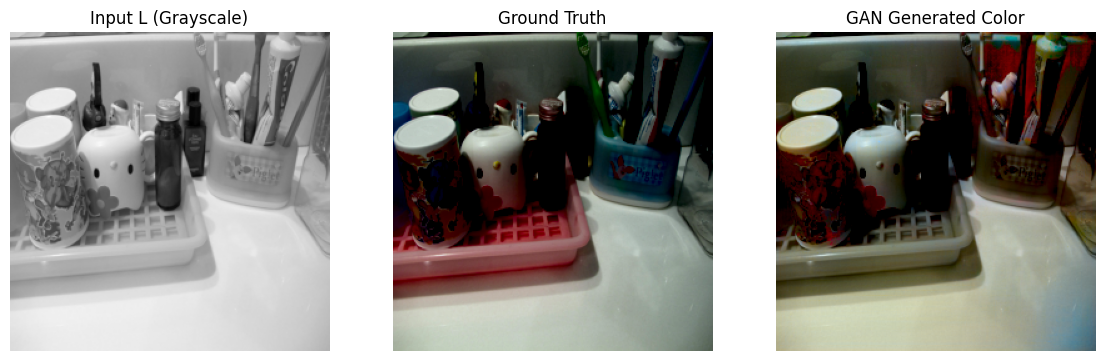

In [ ]:
visualize_gan_output(model, val_dataset, device, idx=11)
visualize_gan_output(model, val_dataset, device, idx=42)
visualize_gan_output(model, val_dataset, device, idx=999)
visualize_gan_output(model, val_dataset, device, idx=93)
visualize_gan_output(model, val_dataset, device, idx=909)
visualize_gan_output(model, val_dataset, device, idx=709)
visualize_gan_output(model, val_dataset, device, idx=528)
visualize_gan_output(model, val_dataset, device, idx=127)
visualize_gan_output(model, val_dataset, device, idx=169)
visualize_gan_output(model, val_dataset, device, idx=16)
visualize_gan_output(model, val_dataset, device, idx=36)
